In [1]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import the carrier history data
PEEE_carrierhistory = pd.read_csv('Data/PvsUdata/carrier_history_peee.csv')
UEEE_carrierhistory = pd.read_csv('Data/PvsUdata/carrier_history_ueee.csv')

# import the forecast data
PEEE_forecast = pd.read_csv('Data/PvsUdata/forecast_accuracy_peee.csv.gz', compression='gzip')
UEEE_forecast = pd.read_csv('Data/PvsUdata/forecast_accuracy_ueee.csv.gz', compression='gzip')

# drop the first column
PEEE_forecast = PEEE_forecast.drop(columns = ['Unnamed: 0'])
UEEE_forecast = UEEE_forecast.drop(columns = ['Unnamed: 0'])


In [3]:
# data preprocessing

# only airline 1 data is needed
PEEE_carrierhistory = PEEE_carrierhistory[PEEE_carrierhistory['carrier'] == 'AL1']
UEEE_carrierhistory = UEEE_carrierhistory[UEEE_carrierhistory['carrier'] == 'AL1']

# replace the NaN values with 0
PEEE_carrierhistory = PEEE_carrierhistory.fillna(0)
UEEE_carrierhistory = UEEE_carrierhistory.fillna(0)
PEEE_forecast = PEEE_forecast.fillna(0)
UEEE_forecast = UEEE_forecast.fillna(0)

# Create a new Forecast error column
PEEE_forecast['Forecast Error'] = PEEE_forecast['fcst_mean'] - PEEE_forecast['sold']
UEEE_forecast['Forecast Error'] = UEEE_forecast['fcst_mean'] - UEEE_forecast['sold']

# Create new forecast error positive and negative columns
PEEE_forecast['Forecast Error Positive'] = np.abs(np.where(PEEE_forecast['Forecast Error'] > 0, PEEE_forecast['Forecast Error'], 0))
PEEE_forecast['Forecast Error Negative'] = np.abs(np.where(PEEE_forecast['Forecast Error'] < 0, PEEE_forecast['Forecast Error'], 0))
UEEE_forecast['Forecast Error Positive'] = np.abs(np.where(UEEE_forecast['Forecast Error'] > 0, UEEE_forecast['Forecast Error'], 0))
UEEE_forecast['Forecast Error Negative'] = np.abs(np.where(UEEE_forecast['Forecast Error'] < 0, UEEE_forecast['Forecast Error'], 0))

# Create a new priceable/yieldable column
PEEE_carrierhistory['Price/Yield'] = PEEE_carrierhistory['sold_priceable'] / PEEE_carrierhistory['sold']
UEEE_carrierhistory['Price/Yield'] = UEEE_carrierhistory['sold_priceable'] / UEEE_carrierhistory['sold']


In [6]:
PEEE_forecast['trial'].value_counts()


trial
0    23940
3    23940
2    23939
1    23936
Name: count, dtype: int64

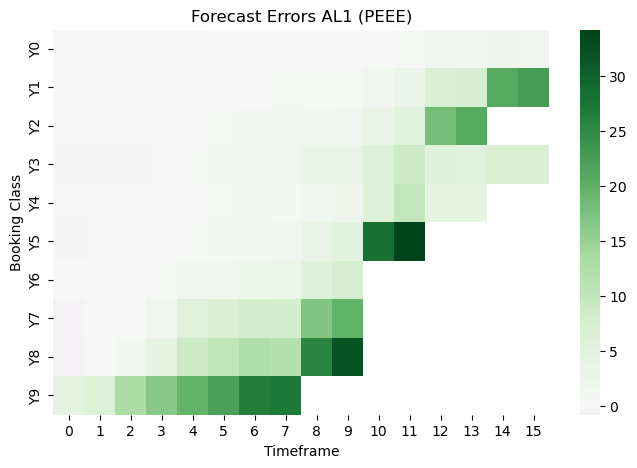

In [8]:
PEEE_forecast
fcst_error_PEEE = PEEE_forecast.groupby(['booking_class', 'timeframe'])[['Forecast Error']].mean().reset_index()
# Create pivot tables for the heatmaps
error_pivot = fcst_error_PEEE.pivot(index='booking_class', columns='timeframe', values='Forecast Error')
plt.figure(figsize=(8,5))
sns.heatmap(error_pivot, cmap='PRGn', center=0, fmt='.1f')
plt.title('Forecast Errors AL1 (PEEE)')
plt.xlabel('Timeframe')
plt.ylabel('Booking Class')
plt.show()

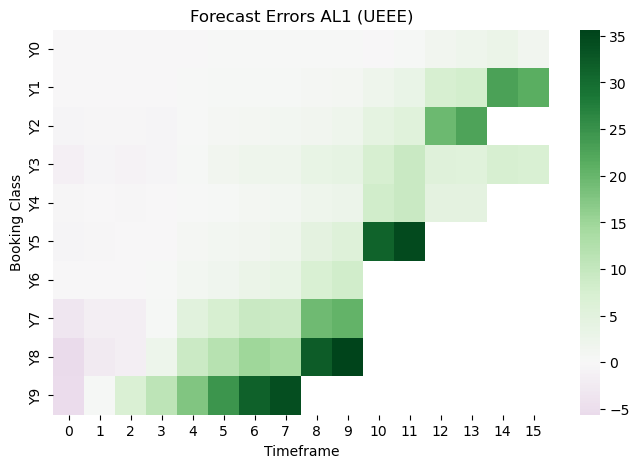

In [7]:
UEEE_forecast
fcst_error_UEEE = UEEE_forecast.groupby(['booking_class', 'timeframe'])[['Forecast Error']].mean().reset_index()
# Create pivot tables for the heatmaps
error_pivotU = fcst_error_UEEE.pivot(index='booking_class', columns='timeframe', values='Forecast Error')
plt.figure(figsize=(8,5))
sns.heatmap(error_pivotU, cmap='PRGn', center=0, fmt='.1f')
plt.title('Forecast Errors AL1 (UEEE)')
plt.xlabel('Timeframe')
plt.ylabel('Booking Class')
plt.show()

In [9]:
PEEE_carrierhistory

,trial,sample,carrier,sold,sold_priceable,revenue,Price/Yield
0,0,50,AL1,10677,5893,3562837.18,0.551934
1,0,51,AL1,11308,6442,3682651.96,0.569685
2,0,52,AL1,10519,6253,3410202.33,0.594448
3,0,53,AL1,11005,6538,3686973.47,0.594094
4,0,54,AL1,9999,6058,3328269.80,0.605861
...,...,...,...,...,...,...,...
595,3,195,AL1,11113,6032,3834715.65,0.542788
596,3,196,AL1,11037,6193,3855571.75,0.561113
597,3,197,AL1,9540,5310,3217446.49,0.556604
598,3,198,AL1,10662,6175,3652374.46,0.579160


In [7]:
# Define custom function for pooled standard deviation
def pooled_std_dev(std_devs, counts):
    """
    Calculate pooled standard deviation.
    std_devs: Series of standard deviations
    counts: Series of corresponding counts (num_obs)
    """
    dof = counts - 1  # degrees of freedom
    weighted_variance = np.sum(dof * (std_devs ** 2))
    total_dof = np.sum(dof)
    return np.sqrt(weighted_variance / total_dof) if total_dof > 0 else 0


# grouping 1
# Group by trial and sample
groupedPEEE1 = PEEE_forecast.groupby(['trial', 'sample']).agg({
    'sold': 'sum',
    'fcst_mean': 'sum',
    'Forecast Error': 'mean',
    'Forecast Error Positive': 'mean',
    'Forecast Error Negative': 'mean'
})

# Calculate pooled std dev separately and merge into grouped DataFrame
std_dev_groupedP1 = PEEE_forecast.groupby(['trial', 'sample'], group_keys=False).apply(
    lambda group: pooled_std_dev(group['fcst_std_dev'], group['num_obs']), include_groups=False
).rename('pooled_fcst_std_dev')

# Add pooled standard deviation to the grouped DataFrame
groupedPEEE1 = groupedPEEE1.merge(std_dev_groupedP1, left_index=True, right_index=True)

# Reset index if needed
groupedPEEE1.reset_index(inplace=True)

groupedUEEE1 = UEEE_forecast.groupby(['trial', 'sample']).agg({
    'sold': 'sum',
    'fcst_mean': 'sum',
    'Forecast Error': 'mean',
    'Forecast Error Positive': 'mean',
    'Forecast Error Negative': 'mean'
})

# Calculate pooled std dev separately and merge into grouped DataFrame
std_dev_groupedU1 = UEEE_forecast.groupby(['trial', 'sample'], group_keys=False).apply(
    lambda group: pooled_std_dev(group['fcst_std_dev'], group['num_obs']), include_groups=False
).rename('pooled_fcst_std_dev')

# Add pooled standard deviation to the grouped DataFrame
groupedUEEE1 = groupedUEEE1.merge(std_dev_groupedU1, left_index=True, right_index=True)

# Reset index if needed
groupedUEEE1.reset_index(inplace=True)




In [8]:
groupedUEEE1

,trial,sample,sold,fcst_mean,Forecast Error,Forecast Error Positive,Forecast Error Negative,pooled_fcst_std_dev
0,0,10,10269,9988.095642,-2.229400,2.393414,4.622814,186.319902
1,0,11,10803,9806.406354,-7.909473,0.933232,8.842705,173.243683
2,0,12,10896,9220.888770,-13.294534,0.845743,14.140277,155.233875
3,0,13,10367,10373.757281,0.053629,4.166534,4.112905,157.802190
4,0,14,10455,10551.357451,0.764742,3.849229,3.084487,158.339070
...,...,...,...,...,...,...,...,...
755,3,195,10998,9108.352070,-14.997206,0.751635,15.748841,122.256996
756,3,196,10999,9522.202828,-11.720612,0.471546,12.192158,122.355784
757,3,197,9643,11632.532137,15.789938,16.870508,1.080571,145.971412
758,3,198,10634,10639.249274,0.041661,4.050877,4.009216,133.476343


In [9]:
# grouping 2

# Create a new column called booking window and populate it based on the timeframes
PEEE_forecast['booking_window'] = np.where(PEEE_forecast['timeframe'] <= 5, 1, np.where(PEEE_forecast['timeframe'] <= 11, 2, 3))
UEEE_forecast['booking_window'] = np.where(UEEE_forecast['timeframe'] <= 5, 1, np.where(UEEE_forecast['timeframe'] <= 11, 2, 3))

# create new columns for the forecast error positive and negative for each booking window 1/2/3
PEEE_forecast['BkgWndw1_Pos'] = np.where((PEEE_forecast['booking_window'] == 1), PEEE_forecast['Forecast Error Positive'], 0)
PEEE_forecast['BkgWndw1_Neg'] = np.where((PEEE_forecast['booking_window'] == 1), PEEE_forecast['Forecast Error Negative'], 0)
PEEE_forecast['BkgWndw2_Pos'] = np.where((PEEE_forecast['booking_window'] == 2), PEEE_forecast['Forecast Error Positive'], 0)
PEEE_forecast['BkgWndw2_Neg'] = np.where((PEEE_forecast['booking_window'] == 2), PEEE_forecast['Forecast Error Negative'], 0)
PEEE_forecast['BkgWndw3_Pos'] = np.where((PEEE_forecast['booking_window'] == 3), PEEE_forecast['Forecast Error Positive'], 0)
PEEE_forecast['BkgWndw3_Neg'] = np.where((PEEE_forecast['booking_window'] == 3), PEEE_forecast['Forecast Error Negative'], 0)

UEEE_forecast['BkgWndw1_Pos'] = np.where((UEEE_forecast['booking_window'] == 1), UEEE_forecast['Forecast Error Positive'], 0)
UEEE_forecast['BkgWndw1_Neg'] = np.where((UEEE_forecast['booking_window'] == 1), UEEE_forecast['Forecast Error Negative'], 0)
UEEE_forecast['BkgWndw2_Pos'] = np.where((UEEE_forecast['booking_window'] == 2), UEEE_forecast['Forecast Error Positive'], 0)
UEEE_forecast['BkgWndw2_Neg'] = np.where((UEEE_forecast['booking_window'] == 2), UEEE_forecast['Forecast Error Negative'], 0)
UEEE_forecast['BkgWndw3_Pos'] = np.where((UEEE_forecast['booking_window'] == 3), UEEE_forecast['Forecast Error Positive'], 0)
UEEE_forecast['BkgWndw3_Neg'] = np.where((UEEE_forecast['booking_window'] == 3), UEEE_forecast['Forecast Error Negative'], 0)

# Group by trial and sample and booking window
groupedPEEE2 = PEEE_forecast.groupby(['trial', 'sample']).agg({
    'sold': 'sum',
    'fcst_mean': 'sum',
    'Forecast Error': 'mean',
    'Forecast Error Positive': 'mean',
    'Forecast Error Negative': 'mean',
    'BkgWndw1_Pos': 'mean',
    'BkgWndw1_Neg': 'mean',
    'BkgWndw2_Pos': 'mean',
    'BkgWndw2_Neg': 'mean',
    'BkgWndw3_Pos': 'mean',
    'BkgWndw3_Neg': 'mean'
})

groupedUEEE2 = UEEE_forecast.groupby(['trial', 'sample']).agg({
    'sold': 'sum',
    'fcst_mean': 'sum',
    'Forecast Error': 'mean',
    'Forecast Error Positive': 'mean',
    'Forecast Error Negative': 'mean',
    'BkgWndw1_Pos': 'mean',
    'BkgWndw1_Neg': 'mean',
    'BkgWndw2_Pos': 'mean',
    'BkgWndw2_Neg': 'mean',
    'BkgWndw3_Pos': 'mean',
    'BkgWndw3_Neg': 'mean'
})



In [10]:
groupedPEEE2

sold     fcst_mean  Forecast Error  Forecast Error Positive  \
trial sample                                                                 
0     10      10113   9926.816598       -1.477646                 2.174156   
      11      10660   9685.868391       -7.731203                 1.233945   
      12      10748   9014.095176      -13.761149                 0.883502   
      13      10263  10440.663539        1.410028                 4.509408   
      14      10356  10581.658193        1.790938                 4.046153   
...             ...           ...             ...                      ...   
3     195     10891   8875.106421      -15.999155                 0.753351   
      196     10846   9404.186115      -11.442967                 0.730768   
      197      9289  11704.696828       19.172197                20.171692   
      198     10406  10642.420681        1.876355                 4.705522   
      199     11190   9369.065368      -14.451862                 0.531528   

              Forecast Error Negative  BkgWndw1_Pos  BkgWndw1_Neg  \
trial sample                                                        
0     10                     3.651802      0.991107      2.403928   
      11                     8.965149      0.418321      5.913480   
      12                    14.644651      0.129671     11.699129   
      13                     3.099380      1.936546      2.704598   
      14                     2.255215      2.019583      1.709008   
...                               ...           ...           ...   
3     195                   16.752506      0.209818     10.295773   
      196                   12.173736      0.231283      7.020653   
      197                    0.999495      4.890796      0.852101   
      198                    2.829167      1.452717      1.948808   
      199                   14.983390      0.216466      7.233460   

              BkgWndw2_Pos  BkgWndw2_Neg  BkgWndw3_Pos  BkgWndw3_Neg  
trial sample                                                          
0     10          0.797991      1.083820      0.385058      0.164055  
      11          0.548781      2.753166      0.266843      0.298503  
      12          0.633494      2.674861      0.120338      0.270661  
      13          2.067298      0.286320      0.505564      0.108462  
      14          1.725171      0.467964      0.301399      0.078243  
...                    ...           ...           ...           ...  
3     195         0.172509      6.308385      0.371025      0.148349  
      196         0.208886      4.899281      0.290599      0.253802  
      197        11.608610      0.147394      3.672286      0.000000  
      198         1.882396      0.834727      1.370408      0.045632  
      199         0.220087      6.882986      0.094975      0.866943  

[760 rows x 11 columns]

In [11]:
# groupings 3
# Create a new column called Booking Class and populate it based on the booking class ranges
PEEE_forecast['Booking Class'] = np.where((PEEE_forecast['booking_class'] == 'Y0') | (PEEE_forecast['booking_class'] == 'Y1') | (PEEE_forecast['booking_class'] == 'Y2') | (PEEE_forecast['booking_class'] == 'Y3'), 'Y0-Y3', 
                                np.where((PEEE_forecast['booking_class'] == 'Y4') | (PEEE_forecast['booking_class'] == 'Y5') | (PEEE_forecast['booking_class'] == 'Y6'), 'Y4-Y6', 
                                np.where((PEEE_forecast['booking_class'] == 'Y7') | (PEEE_forecast['booking_class'] == 'Y8') | (PEEE_forecast['booking_class'] == 'Y9'), 'Y7-Y9', 0)))

UEEE_forecast['Booking Class'] = np.where((UEEE_forecast['booking_class'] == 'Y0') | (UEEE_forecast['booking_class'] == 'Y1') | (UEEE_forecast['booking_class'] == 'Y2') | (UEEE_forecast['booking_class'] == 'Y3'), 'Y0-Y3', 
                                np.where((UEEE_forecast['booking_class'] == 'Y4') | (UEEE_forecast['booking_class'] == 'Y5') | (UEEE_forecast['booking_class'] == 'Y6'), 'Y4-Y6', 
                                np.where((UEEE_forecast['booking_class'] == 'Y7') | (UEEE_forecast['booking_class'] == 'Y8') | (UEEE_forecast['booking_class'] == 'Y9'), 'Y7-Y9', 0)))

# create new columns for the forecast error positive and negative for each booking class Y0-Y3/Y4-Y6/Y7-Y9
PEEE_forecast['BkgClsY0Y3_Pos'] = np.where((PEEE_forecast['Booking Class'] == 'Y0-Y3'), PEEE_forecast['Forecast Error Positive'], 0)
PEEE_forecast['BkgClsY0Y3_Neg'] = np.where((PEEE_forecast['Booking Class'] == 'Y0-Y3'), PEEE_forecast['Forecast Error Negative'], 0)
PEEE_forecast['BkgClsY4Y6_Pos'] = np.where((PEEE_forecast['Booking Class'] == 'Y4-Y6'), PEEE_forecast['Forecast Error Positive'], 0)
PEEE_forecast['BkgClsY4Y6_Neg'] = np.where((PEEE_forecast['Booking Class'] == 'Y4-Y6'), PEEE_forecast['Forecast Error Negative'], 0)
PEEE_forecast['BkgClsY7Y9_Pos'] = np.where((PEEE_forecast['Booking Class'] == 'Y7-Y9'), PEEE_forecast['Forecast Error Positive'], 0)
PEEE_forecast['BkgClsY7Y9_Neg'] = np.where((PEEE_forecast['Booking Class'] == 'Y7-Y9'), PEEE_forecast['Forecast Error Negative'], 0)

UEEE_forecast['BkgClsY0Y3_Pos'] = np.where((UEEE_forecast['Booking Class'] == 'Y0-Y3'), UEEE_forecast['Forecast Error Positive'], 0)
UEEE_forecast['BkgClsY0Y3_Neg'] = np.where((UEEE_forecast['Booking Class'] == 'Y0-Y3'), UEEE_forecast['Forecast Error Negative'], 0)
UEEE_forecast['BkgClsY4Y6_Pos'] = np.where((UEEE_forecast['Booking Class'] == 'Y4-Y6'), UEEE_forecast['Forecast Error Positive'], 0)
UEEE_forecast['BkgClsY4Y6_Neg'] = np.where((UEEE_forecast['Booking Class'] == 'Y4-Y6'), UEEE_forecast['Forecast Error Negative'], 0)
UEEE_forecast['BkgClsY7Y9_Pos'] = np.where((UEEE_forecast['Booking Class'] == 'Y7-Y9'), UEEE_forecast['Forecast Error Positive'], 0)
UEEE_forecast['BkgClsY7Y9_Neg'] = np.where((UEEE_forecast['Booking Class'] == 'Y7-Y9'), UEEE_forecast['Forecast Error Negative'], 0)

# Group by trial and sample and booking class
groupedPEEE3 = PEEE_forecast.groupby(['trial', 'sample']).agg({
    'sold': 'sum',
    'fcst_mean': 'sum',
    'Forecast Error': 'mean',
    'Forecast Error Positive': 'mean',
    'Forecast Error Negative': 'mean',
    'BkgClsY0Y3_Pos': 'mean',
    'BkgClsY0Y3_Neg': 'mean',
    'BkgClsY4Y6_Pos': 'mean',
    'BkgClsY4Y6_Neg': 'mean',
    'BkgClsY7Y9_Pos': 'mean',
    'BkgClsY7Y9_Neg': 'mean'
})

groupedUEEE3 = UEEE_forecast.groupby(['trial', 'sample']).agg({
    'sold': 'sum',
    'fcst_mean': 'sum',
    'Forecast Error': 'mean',
    'Forecast Error Positive': 'mean',
    'Forecast Error Negative': 'mean',
    'BkgClsY0Y3_Pos': 'mean',
    'BkgClsY0Y3_Neg': 'mean',
    'BkgClsY4Y6_Pos': 'mean',
    'BkgClsY4Y6_Neg': 'mean',
    'BkgClsY7Y9_Pos': 'mean',
    'BkgClsY7Y9_Neg': 'mean'
})

In [12]:
groupedPEEE3

sold     fcst_mean  Forecast Error  Forecast Error Positive  \
trial sample                                                                 
0     10      10113   9926.816598       -1.477646                 2.174156   
      11      10660   9685.868391       -7.731203                 1.233945   
      12      10748   9014.095176      -13.761149                 0.883502   
      13      10263  10440.663539        1.410028                 4.509408   
      14      10356  10581.658193        1.790938                 4.046153   
...             ...           ...             ...                      ...   
3     195     10891   8875.106421      -15.999155                 0.753351   
      196     10846   9404.186115      -11.442967                 0.730768   
      197      9289  11704.696828       19.172197                20.171692   
      198     10406  10642.420681        1.876355                 4.705522   
      199     11190   9369.065368      -14.451862                 0.531528   

              Forecast Error Negative  BkgClsY0Y3_Pos  BkgClsY0Y3_Neg  \
trial sample                                                            
0     10                     3.651802        0.852521        1.143219   
      11                     8.965149        0.789216        1.575248   
      12                    14.644651        0.484042        2.259250   
      13                     3.099380        1.795923        0.487058   
      14                     2.255215        1.306756        0.833997   
...                               ...             ...             ...   
3     195                   16.752506        0.570254        3.903746   
      196                   12.173736        0.449678        3.283391   
      197                    0.999495        6.207617        0.447764   
      198                    2.829167        2.605643        0.591947   
      199                   14.983390        0.285952        5.072688   

              BkgClsY4Y6_Pos  BkgClsY4Y6_Neg  BkgClsY7Y9_Pos  BkgClsY7Y9_Neg  
trial sample                                                                  
0     10            0.814555        0.384793        0.507080        2.123790  
      11            0.444729        1.353926        0.000000        6.035975  
      12            0.369061        1.355355        0.030399       11.030047  
      13            0.903617        0.654330        1.809868        1.957992  
      14            0.428085        0.756026        2.311311        0.665192  
...                      ...             ...             ...             ...  
3     195           0.183097        3.348869        0.000000        9.499891  
      196           0.116232        2.461492        0.164858        6.428852  
      197           4.621871        0.313329        9.342204        0.238401  
      198           1.045947        0.726123        1.053932        1.511097  
      199           0.104858        3.798223        0.140718        6.112478  

[760 rows x 11 columns]

In [13]:
# merge the 3 grouped dataframes and delete the unnecessary columns
groupedPEEE = pd.merge(groupedPEEE1, groupedPEEE2, on=['trial', 'sample'])
groupedPEEE = pd.merge(groupedPEEE, groupedPEEE3, on=['trial', 'sample'])
groupedPEEE = groupedPEEE.drop(columns = ['sold_x', 'fcst_mean_x', 'Forecast Error_x', 'Forecast Error Positive_x', 'Forecast Error Negative_x', 'sold_y', 'fcst_mean_y', 'Forecast Error_y', 'Forecast Error Positive_y', 'Forecast Error Negative_y'])

# rearrange the columns so that trial, sample, sold, fcst_mean, Forecast Error, Forecast Error Positive, Forecast Error Negative and pooled_fcst_std_dev are at the beginning
groupedPEEE = groupedPEEE[['trial', 'sample', 'sold', 'fcst_mean', 'Forecast Error', 'Forecast Error Positive', 'Forecast Error Negative', 'pooled_fcst_std_dev', 'BkgWndw1_Pos', 'BkgWndw1_Neg', 'BkgWndw2_Pos', 'BkgWndw2_Neg', 'BkgWndw3_Pos', 'BkgWndw3_Neg', 'BkgClsY0Y3_Pos', 'BkgClsY0Y3_Neg', 'BkgClsY4Y6_Pos', 'BkgClsY4Y6_Neg', 'BkgClsY7Y9_Pos', 'BkgClsY7Y9_Neg']]

groupedUEEE = pd.merge(groupedUEEE1, groupedUEEE2, on=['trial', 'sample'])
groupedUEEE = pd.merge(groupedUEEE, groupedUEEE3, on=['trial', 'sample'])
groupedUEEE = groupedUEEE.drop(columns = ['sold_x', 'fcst_mean_x', 'Forecast Error_x', 'Forecast Error Positive_x', 'Forecast Error Negative_x', 'sold_y', 'fcst_mean_y', 'Forecast Error_y', 'Forecast Error Positive_y', 'Forecast Error Negative_y'])

# rearrange the columns so that trial, sample, sold, fcst_mean, Forecast Error, Forecast Error Positive, Forecast Error Negative and pooled_fcst_std_dev are at the beginning
groupedUEEE = groupedUEEE[['trial', 'sample', 'sold', 'fcst_mean', 'Forecast Error', 'Forecast Error Positive', 'Forecast Error Negative', 'pooled_fcst_std_dev', 'BkgWndw1_Pos', 'BkgWndw1_Neg', 'BkgWndw2_Pos', 'BkgWndw2_Neg', 'BkgWndw3_Pos', 'BkgWndw3_Neg', 'BkgClsY0Y3_Pos', 'BkgClsY0Y3_Neg', 'BkgClsY4Y6_Pos', 'BkgClsY4Y6_Neg', 'BkgClsY7Y9_Pos', 'BkgClsY7Y9_Neg']]

In [14]:
groupedUEEE

,trial,sample,sold,fcst_mean,Forecast Error,Forecast Error Positive,Forecast Error Negative,pooled_fcst_std_dev,BkgWndw1_Pos,BkgWndw1_Neg,BkgWndw2_Pos,BkgWndw2_Neg,BkgWndw3_Pos,BkgWndw3_Neg,BkgClsY0Y3_Pos,BkgClsY0Y3_Neg,BkgClsY4Y6_Pos,BkgClsY4Y6_Neg,BkgClsY7Y9_Pos,BkgClsY7Y9_Neg
0,0,10,10269,9988.095642,-2.229400,2.393414,4.622814,186.319902,0.976845,3.264475,0.786680,1.284883,0.629890,0.073456,1.129981,1.318150,0.734720,0.548899,0.528713,2.755764
1,0,11,10803,9806.406354,-7.909473,0.933232,8.842705,173.243683,0.391569,6.694674,0.367118,1.965969,0.174544,0.182062,0.360149,1.605451,0.362486,1.251464,0.210596,5.985790
2,0,12,10896,9220.888770,-13.294534,0.845743,14.140277,155.233875,0.077252,11.108705,0.422093,2.687081,0.346398,0.344490,0.567689,2.357423,0.278054,0.901165,0.000000,10.881688
3,0,13,10367,10373.757281,0.053629,4.166534,4.112905,157.802190,1.158950,3.576233,2.252797,0.450055,0.754788,0.086618,2.353969,0.541590,0.492658,0.688597,1.319907,2.882718
4,0,14,10455,10551.357451,0.764742,3.849229,3.084487,158.339070,1.199381,2.573318,2.301701,0.424026,0.348147,0.087143,1.347206,1.026241,1.105342,0.637121,1.396681,1.421126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,3,195,10998,9108.352070,-14.997206,0.751635,15.748841,122.256996,0.107034,9.714366,0.385418,5.801891,0.259183,0.232584,0.365423,4.820856,0.283572,3.292150,0.102641,7.635834
756,3,196,10999,9522.202828,-11.720612,0.471546,12.192158,122.355784,0.290488,7.069489,0.029256,4.406582,0.151802,0.716087,0.213177,4.047591,0.122892,2.324090,0.135477,5.820477
757,3,197,9643,11632.532137,15.789938,16.870508,1.080571,145.971412,4.666205,0.866455,9.262525,0.214116,2.941778,0.000000,5.088575,0.528536,3.244862,0.507863,8.537071,0.044172
758,3,198,10634,10639.249274,0.041661,4.050877,4.009216,133.476343,1.731413,3.051904,1.350207,0.904323,0.969256,0.052989,1.655550,1.031067,0.770207,0.574406,1.625119,2.403742


In [15]:
groupedPEEE

,trial,sample,sold,fcst_mean,Forecast Error,Forecast Error Positive,Forecast Error Negative,pooled_fcst_std_dev,BkgWndw1_Pos,BkgWndw1_Neg,BkgWndw2_Pos,BkgWndw2_Neg,BkgWndw3_Pos,BkgWndw3_Neg,BkgClsY0Y3_Pos,BkgClsY0Y3_Neg,BkgClsY4Y6_Pos,BkgClsY4Y6_Neg,BkgClsY7Y9_Pos,BkgClsY7Y9_Neg
0,0,10,10113,9926.816598,-1.477646,2.174156,3.651802,182.564469,0.991107,2.403928,0.797991,1.083820,0.385058,0.164055,0.852521,1.143219,0.814555,0.384793,0.507080,2.123790
1,0,11,10660,9685.868391,-7.731203,1.233945,8.965149,153.432118,0.418321,5.913480,0.548781,2.753166,0.266843,0.298503,0.789216,1.575248,0.444729,1.353926,0.000000,6.035975
2,0,12,10748,9014.095176,-13.761149,0.883502,14.644651,92.656703,0.129671,11.699129,0.633494,2.674861,0.120338,0.270661,0.484042,2.259250,0.369061,1.355355,0.030399,11.030047
3,0,13,10263,10440.663539,1.410028,4.509408,3.099380,67.390865,1.936546,2.704598,2.067298,0.286320,0.505564,0.108462,1.795923,0.487058,0.903617,0.654330,1.809868,1.957992
4,0,14,10356,10581.658193,1.790938,4.046153,2.255215,61.246972,2.019583,1.709008,1.725171,0.467964,0.301399,0.078243,1.306756,0.833997,0.428085,0.756026,2.311311,0.665192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,3,195,10891,8875.106421,-15.999155,0.753351,16.752506,32.298924,0.209818,10.295773,0.172509,6.308385,0.371025,0.148349,0.570254,3.903746,0.183097,3.348869,0.000000,9.499891
756,3,196,10846,9404.186115,-11.442967,0.730768,12.173736,25.138978,0.231283,7.020653,0.208886,4.899281,0.290599,0.253802,0.449678,3.283391,0.116232,2.461492,0.164858,6.428852
757,3,197,9289,11704.696828,19.172197,20.171692,0.999495,21.487158,4.890796,0.852101,11.608610,0.147394,3.672286,0.000000,6.207617,0.447764,4.621871,0.313329,9.342204,0.238401
758,3,198,10406,10642.420681,1.876355,4.705522,2.829167,23.089700,1.452717,1.948808,1.882396,0.834727,1.370408,0.045632,2.605643,0.591947,1.045947,0.726123,1.053932,1.511097


In [32]:
# merge the carrier history data with the forecast data

PEEE = pd.merge(PEEE_carrierhistory, groupedPEEE, on=['trial', 'sample'])
UEEE = pd.merge(UEEE_carrierhistory, groupedUEEE, on=['trial', 'sample'])

# drop sold, carrier, sold_priceable columns
PEEE = PEEE.drop(columns = ['sold_x', 'sold_y', 'carrier', 'sold_priceable'])
UEEE = UEEE.drop(columns = ['sold_x', 'sold_y', 'carrier', 'sold_priceable'])

PEEE

,trial,sample,revenue,Price/Yield,fcst_mean,Forecast Error,Forecast Error Positive,Forecast Error Negative,pooled_fcst_std_dev,BkgWndw1_Pos,...,BkgWndw2_Pos,BkgWndw2_Neg,BkgWndw3_Pos,BkgWndw3_Neg,BkgClsY0Y3_Pos,BkgClsY0Y3_Neg,BkgClsY4Y6_Pos,BkgClsY4Y6_Neg,BkgClsY7Y9_Pos,BkgClsY7Y9_Neg
0,0,50,3562837.18,0.551934,10959.294682,4.192815,7.339104,3.146289,40.839811,3.704214,...,3.292272,0.887466,0.342619,0.154005,0.797325,1.537021,1.096020,1.161072,5.445759,0.448197
1,0,51,3682651.96,0.569685,10237.738752,-6.740169,1.441265,8.181434,36.368062,0.344215,...,0.537995,2.188259,0.559055,0.055924,0.931724,1.687621,0.218614,1.019744,0.290927,5.474069
2,0,52,3410202.33,0.594448,11476.762359,9.736209,10.716905,0.980696,33.709713,6.007073,...,3.833288,0.498958,0.876544,0.062009,1.808975,0.527055,1.086054,0.453641,7.821877,0.000000
3,0,53,3686973.47,0.594094,10081.996473,-5.642885,2.269775,7.912660,36.218509,1.346621,...,0.602451,2.610549,0.320703,0.332507,0.446040,2.492871,0.368385,1.569911,1.455349,3.849878
4,0,54,3328269.80,0.605861,11641.954671,14.991704,15.398015,0.406312,29.179940,7.234925,...,6.450720,0.091476,1.712371,0.000000,3.473380,0.334077,2.898390,0.072235,9.026246,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,3,195,3834715.65,0.542788,8875.106421,-15.999155,0.753351,16.752506,32.298924,0.209818,...,0.172509,6.308385,0.371025,0.148349,0.570254,3.903746,0.183097,3.348869,0.000000,9.499891
596,3,196,3855571.75,0.561113,9404.186115,-11.442967,0.730768,12.173736,25.138978,0.231283,...,0.208886,4.899281,0.290599,0.253802,0.449678,3.283391,0.116232,2.461492,0.164858,6.428852
597,3,197,3217446.49,0.556604,11704.696828,19.172197,20.171692,0.999495,21.487158,4.890796,...,11.608610,0.147394,3.672286,0.000000,6.207617,0.447764,4.621871,0.313329,9.342204,0.238401
598,3,198,3652374.46,0.579160,10642.420681,1.876355,4.705522,2.829167,23.089700,1.452717,...,1.882396,0.834727,1.370408,0.045632,2.605643,0.591947,1.045947,0.726123,1.053932,1.511097


In [33]:
# creating a large dataframe with all the data by merging the PEEE and UEEE dataframes
data = pd.merge(PEEE, UEEE, on=['trial', 'sample'], suffixes=('_P', '_U'))
data['revenue_diff_U-P'] = data['revenue_U'] - data['revenue_P']
# keep the same columns next to each other for easy comparison - revenue for PEEE and UEEE, price/yield for PEEE and UEEE, Forecast Error for PEEE and UEEE, Forecast Error Positive for PEEE and UEEE, Forecast Error Negative for PEEE and UEEE, pooled_fcst_std_dev for PEEE and UEEE, BkgWndw1_Pos for PEEE and UEEE, BkgWndw1_Neg for PEEE and UEEE, BkgWndw2_Pos for PEEE and UEEE, BkgWndw2_Neg for PEEE and UEEE, BkgWndw3_Pos for PEEE and UEEE, BkgWndw3_Neg for PEEE and UEEE, BkgClsY0Y3_Pos for PEEE and UEEE, BkgClsY0Y3_Neg for PEEE and UEEE, BkgClsY4Y6_Pos for PEEE and UEEE, BkgClsY4Y6_Neg for PEEE and UEEE, BkgClsY7Y9_Pos for PEEE and UEEE, BkgClsY7Y9_Neg for PEEE and UEEE
data = data[['trial', 'sample', 'revenue_P', 'revenue_U', 'revenue_diff_U-P', 'Price/Yield_P', 'Price/Yield_U', 'fcst_mean_P', 'fcst_mean_U', 'Forecast Error_P', 'Forecast Error_U', 'Forecast Error Positive_P', 'Forecast Error Positive_U', 'Forecast Error Negative_P', 'Forecast Error Negative_U', 'pooled_fcst_std_dev_P', 'pooled_fcst_std_dev_U', 'BkgWndw1_Pos_P', 'BkgWndw1_Pos_U', 'BkgWndw1_Neg_P', 'BkgWndw1_Neg_U', 'BkgWndw2_Pos_P', 'BkgWndw2_Pos_U', 'BkgWndw2_Neg_P', 'BkgWndw2_Neg_U', 'BkgWndw3_Pos_P', 'BkgWndw3_Pos_U', 'BkgWndw3_Neg_P', 'BkgWndw3_Neg_U', 'BkgClsY0Y3_Pos_P', 'BkgClsY0Y3_Pos_U', 'BkgClsY0Y3_Neg_P', 'BkgClsY0Y3_Neg_U', 'BkgClsY4Y6_Pos_P', 'BkgClsY4Y6_Pos_U', 'BkgClsY4Y6_Neg_P', 'BkgClsY4Y6_Neg_U', 'BkgClsY7Y9_Pos_P', 'BkgClsY7Y9_Pos_U', 'BkgClsY7Y9_Neg_P', 'BkgClsY7Y9_Neg_U']]

In [34]:
data.columns

Index(['trial', 'sample', 'revenue_P', 'revenue_U', 'revenue_diff_U-P',
       'Price/Yield_P', 'Price/Yield_U', 'fcst_mean_P', 'fcst_mean_U',
       'Forecast Error_P', 'Forecast Error_U', 'Forecast Error Positive_P',
       'Forecast Error Positive_U', 'Forecast Error Negative_P',
       'Forecast Error Negative_U', 'pooled_fcst_std_dev_P',
       'pooled_fcst_std_dev_U', 'BkgWndw1_Pos_P', 'BkgWndw1_Pos_U',
       'BkgWndw1_Neg_P', 'BkgWndw1_Neg_U', 'BkgWndw2_Pos_P', 'BkgWndw2_Pos_U',
       'BkgWndw2_Neg_P', 'BkgWndw2_Neg_U', 'BkgWndw3_Pos_P', 'BkgWndw3_Pos_U',
       'BkgWndw3_Neg_P', 'BkgWndw3_Neg_U', 'BkgClsY0Y3_Pos_P',
       'BkgClsY0Y3_Pos_U', 'BkgClsY0Y3_Neg_P', 'BkgClsY0Y3_Neg_U',
       'BkgClsY4Y6_Pos_P', 'BkgClsY4Y6_Pos_U', 'BkgClsY4Y6_Neg_P',
       'BkgClsY4Y6_Neg_U', 'BkgClsY7Y9_Pos_P', 'BkgClsY7Y9_Pos_U',
       'BkgClsY7Y9_Neg_P', 'BkgClsY7Y9_Neg_U'],
      dtype='object')

In [35]:
# export the data to a csv file
data.to_csv('Data/PvsUdata/MergedData2.csv', index=False)

In [3]:
data = pd.read_csv('Data/PvsUdata/MergedData2.csv')

In [4]:
# Calculate average revenues
udp_avg_revenue = data['revenue_U'].mean()
probp_avg_revenue = data['revenue_P'].mean()

print(f"Average Revenue for UDP: {udp_avg_revenue:.2f}")
print(f"Average Revenue for ProBP: {probp_avg_revenue:.2f}")

Average Revenue for UDP: 3508559.12
Average Revenue for ProBP: 3477599.53


In [5]:
# Label scenarios where ProBP outperforms UDP
data['ProBP_wins'] = (data['revenue_P'] > data['revenue_U']).astype(int)

In [6]:
probp_win_percentage = data['ProBP_wins'].mean() * 100
print(f"Percentage of scenarios where ProBP wins: {probp_win_percentage:.2f}%")

Percentage of scenarios where ProBP wins: 22.33%


In [7]:
# calculate the average revenue difference percentage
data['revenue_diff_percentage'] = (data['revenue_diff_U-P'] / data['revenue_P']) * 100
print(f"Average Revenue Difference Percentage: {data['revenue_diff_percentage'].mean():.2f}")

Average Revenue Difference Percentage: 0.85
